<a href="https://colab.research.google.com/github/MuhaddidAlavi/Time_Serise_Anomaly_Detection_with_LSTM_Autoencoders.ipynb/blob/main/Time_Serise_Anomaly_Detection_with_LSTM_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
register_matplotlib_converters()
sns.set(style = 'whitegrid',palette = 'muted',font_scale = 1.5)
rcParams['figure.figsize']=18,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 57.1MB/s]


In [ ]:
df.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [ ]:
df.shape

(8192, 1)

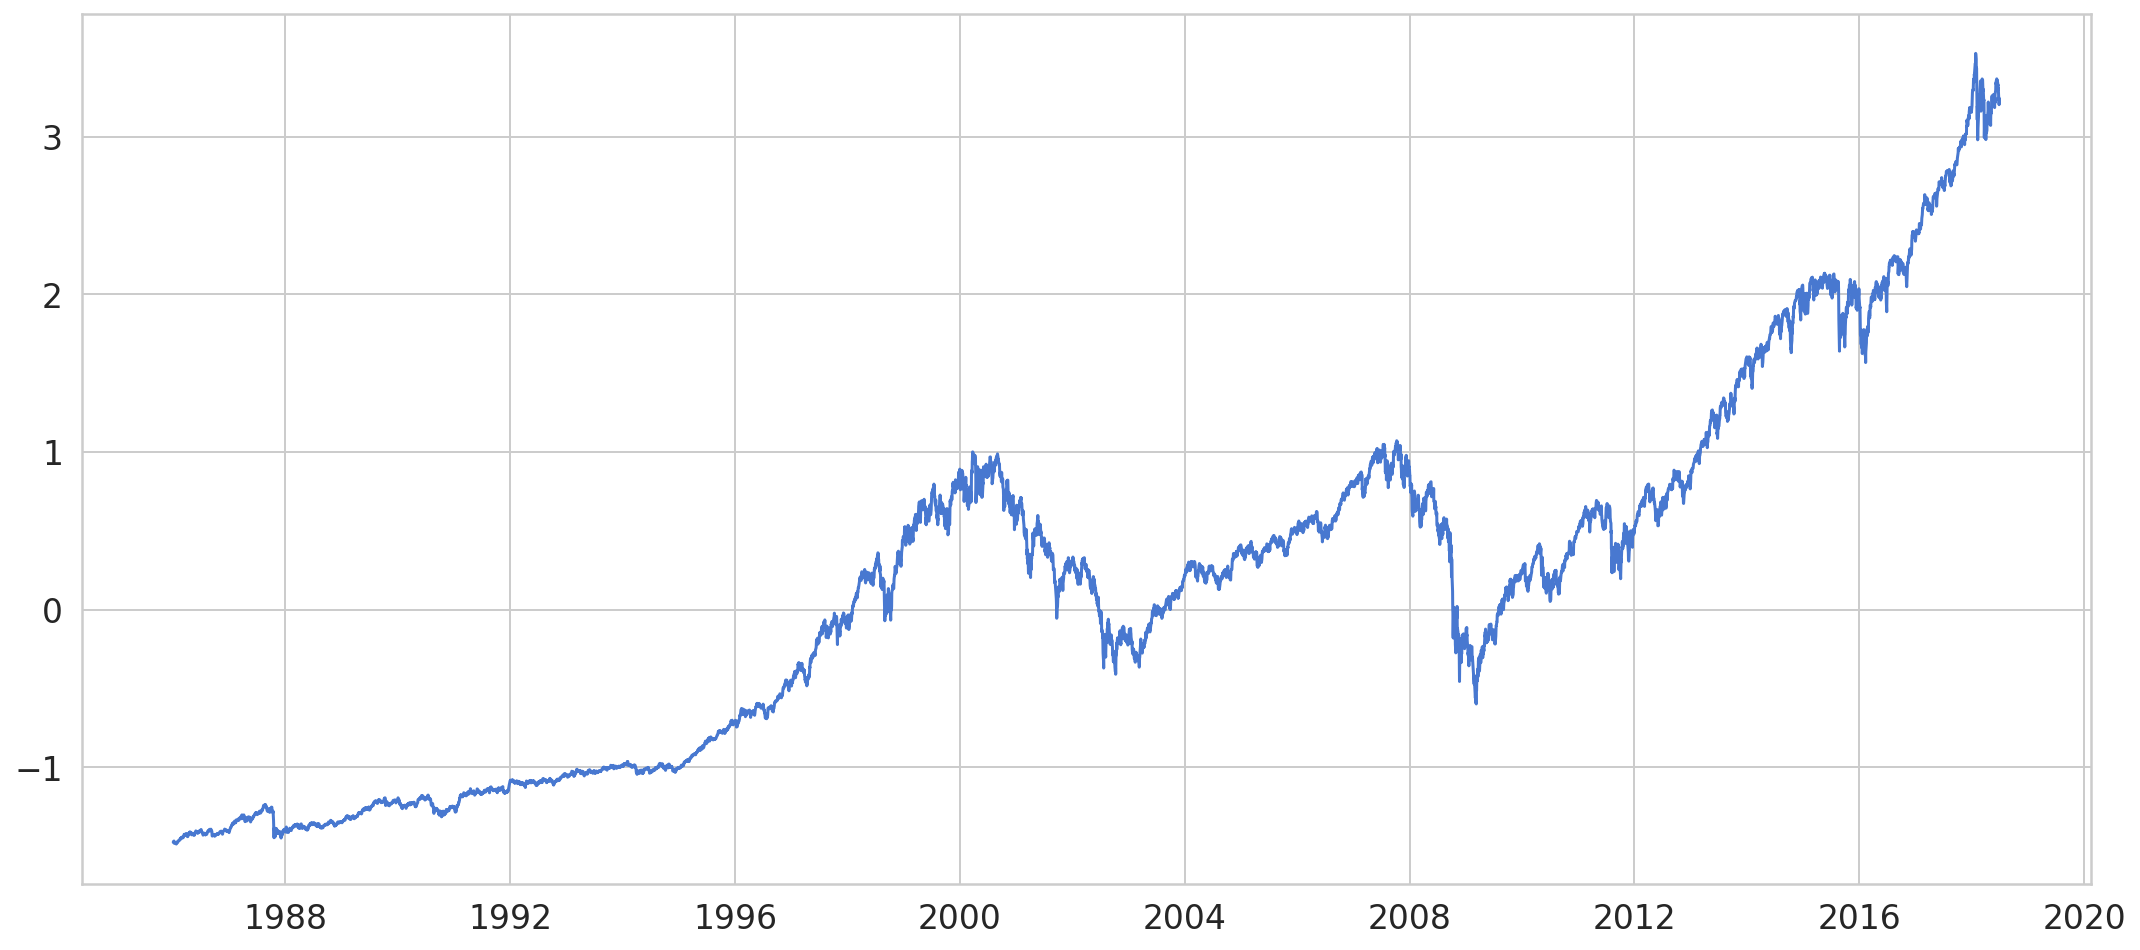

In [ ]:
plt.plot(df,label = 'price')

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)
print(X_train.shape)

(7752, 30, 1)


In [ ]:

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 6s 29ms/step - loss: 0.1691 - val_loss: 0.1827
Epoch 2/10
218/218 [==============================] - 6s 26ms/step - loss: 0.0934 - val_loss: 0.1589
Epoch 3/10
218/218 [==============================] - 6s 26ms/step - loss: 0.0964 - val_loss: 0.1311
Epoch 4/10
218/218 [==============================] - 6s 27ms/step - loss: 0.0879 - val_loss: 0.1037
Epoch 5/10
218/218 [==============================] - 6s 27ms/step - loss: 0.0918 - val_loss: 0.0657
Epoch 6/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1047 - val_loss: 0.0950
Epoch 7/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1007 - val_loss: 0.0775
Epoch 8/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1091 - val_loss: 0.0647
Epoch 9/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1036 - val_loss: 0.1186
Epoch 10/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1129 - val_lo

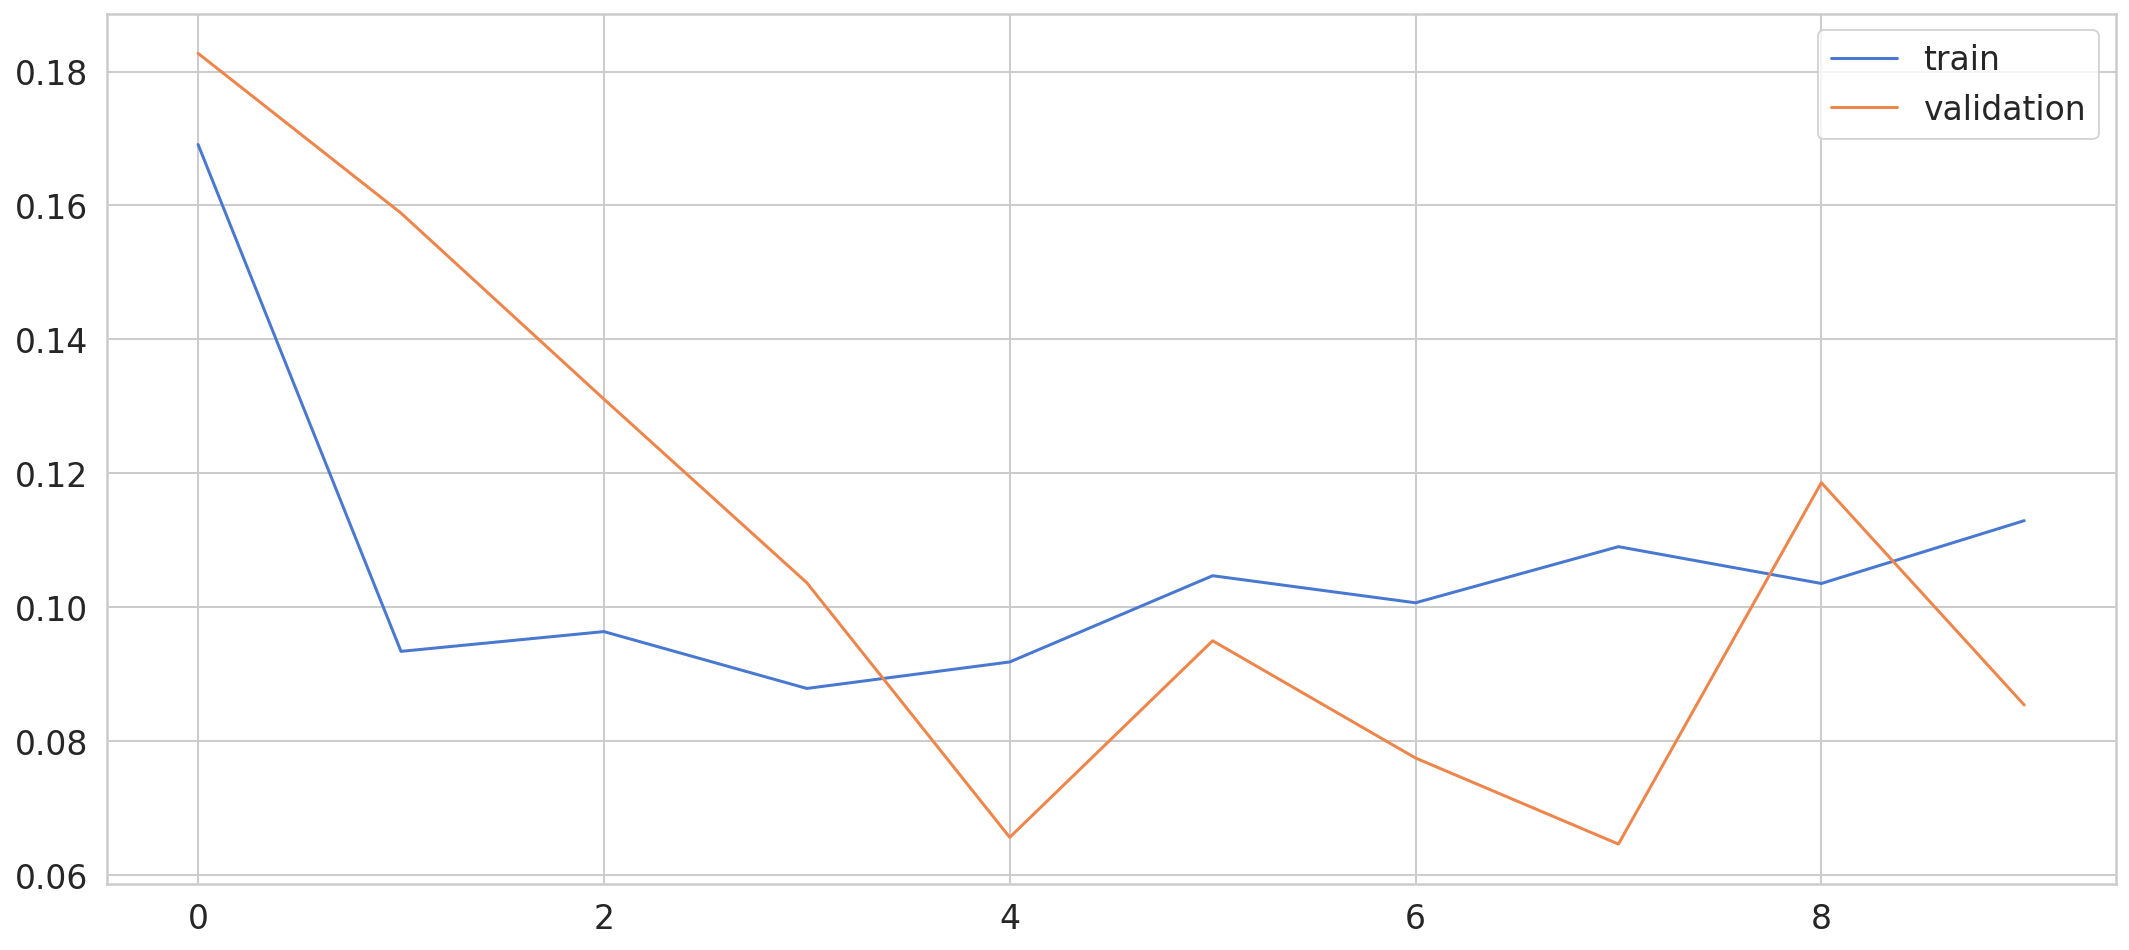

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
train_mae_loss.shape

(7752, 1)

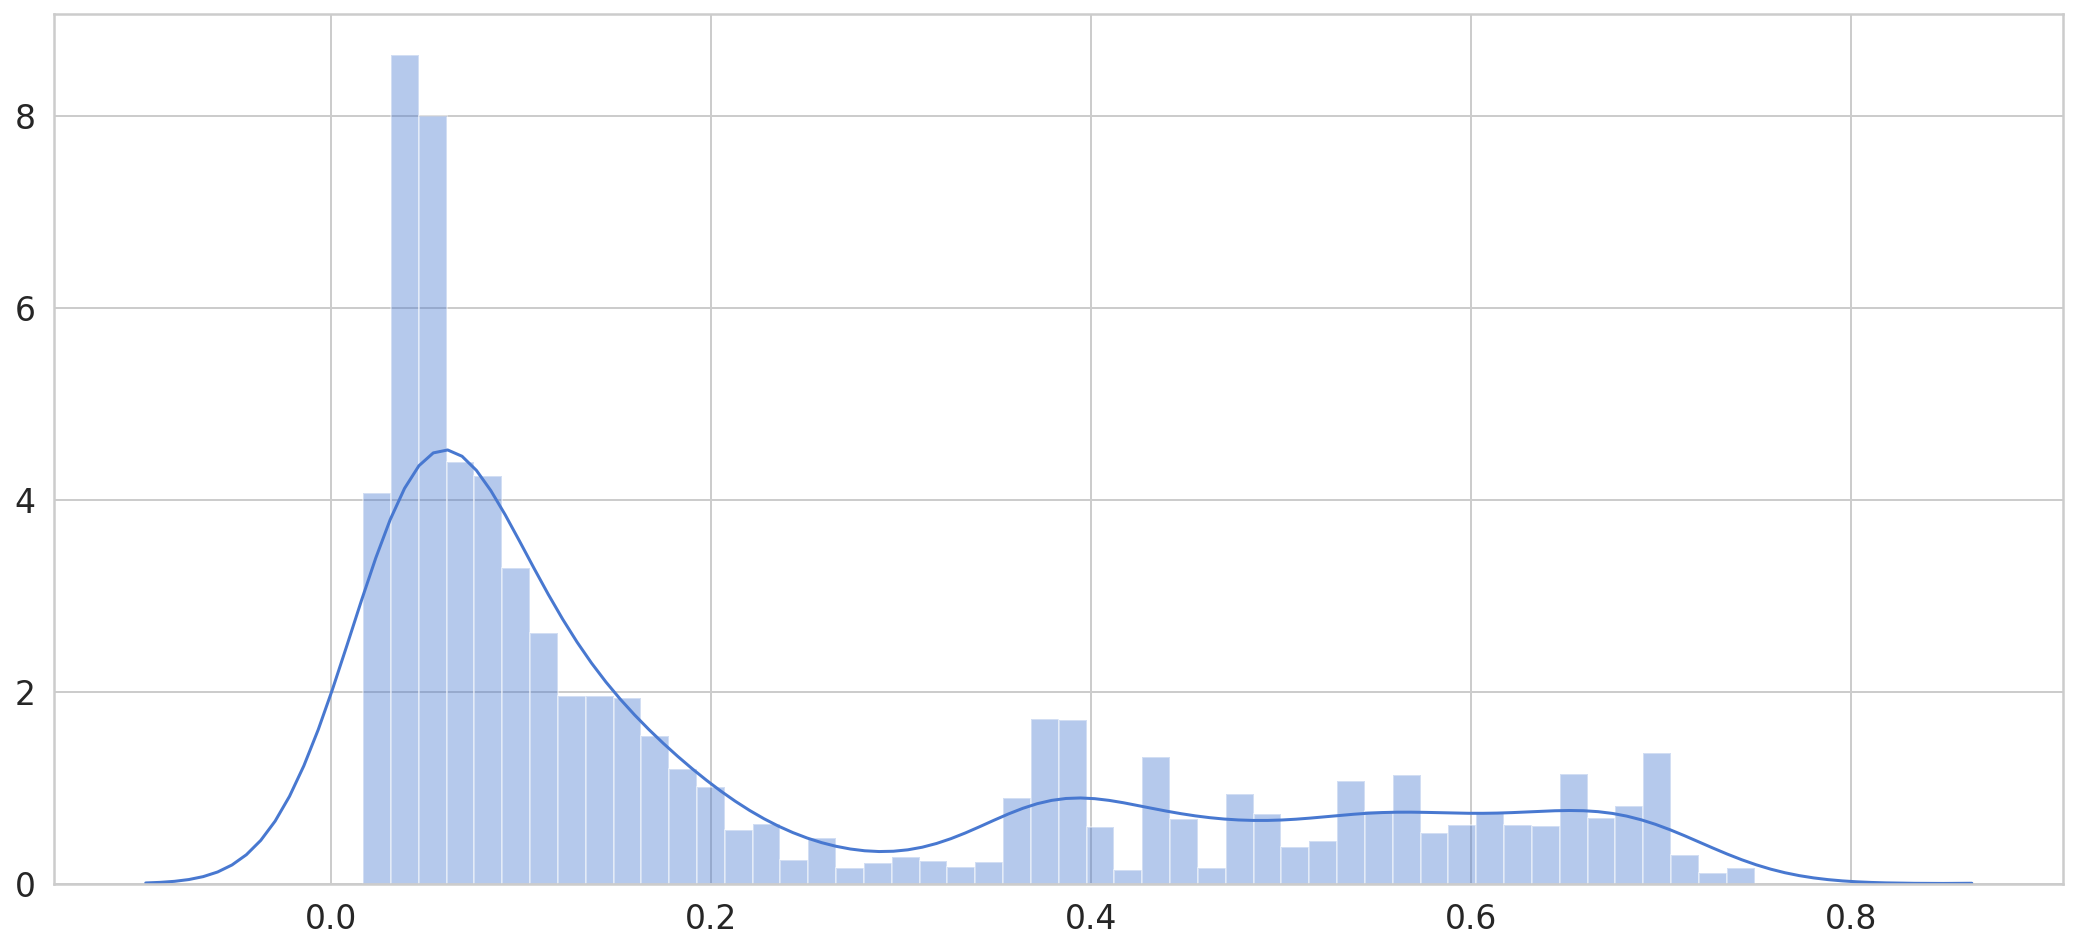

In [ ]:
sns.distplot(train_mae_loss,bins=50,kde=True)

In [ ]:
THRESHOLD = 0.50

In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

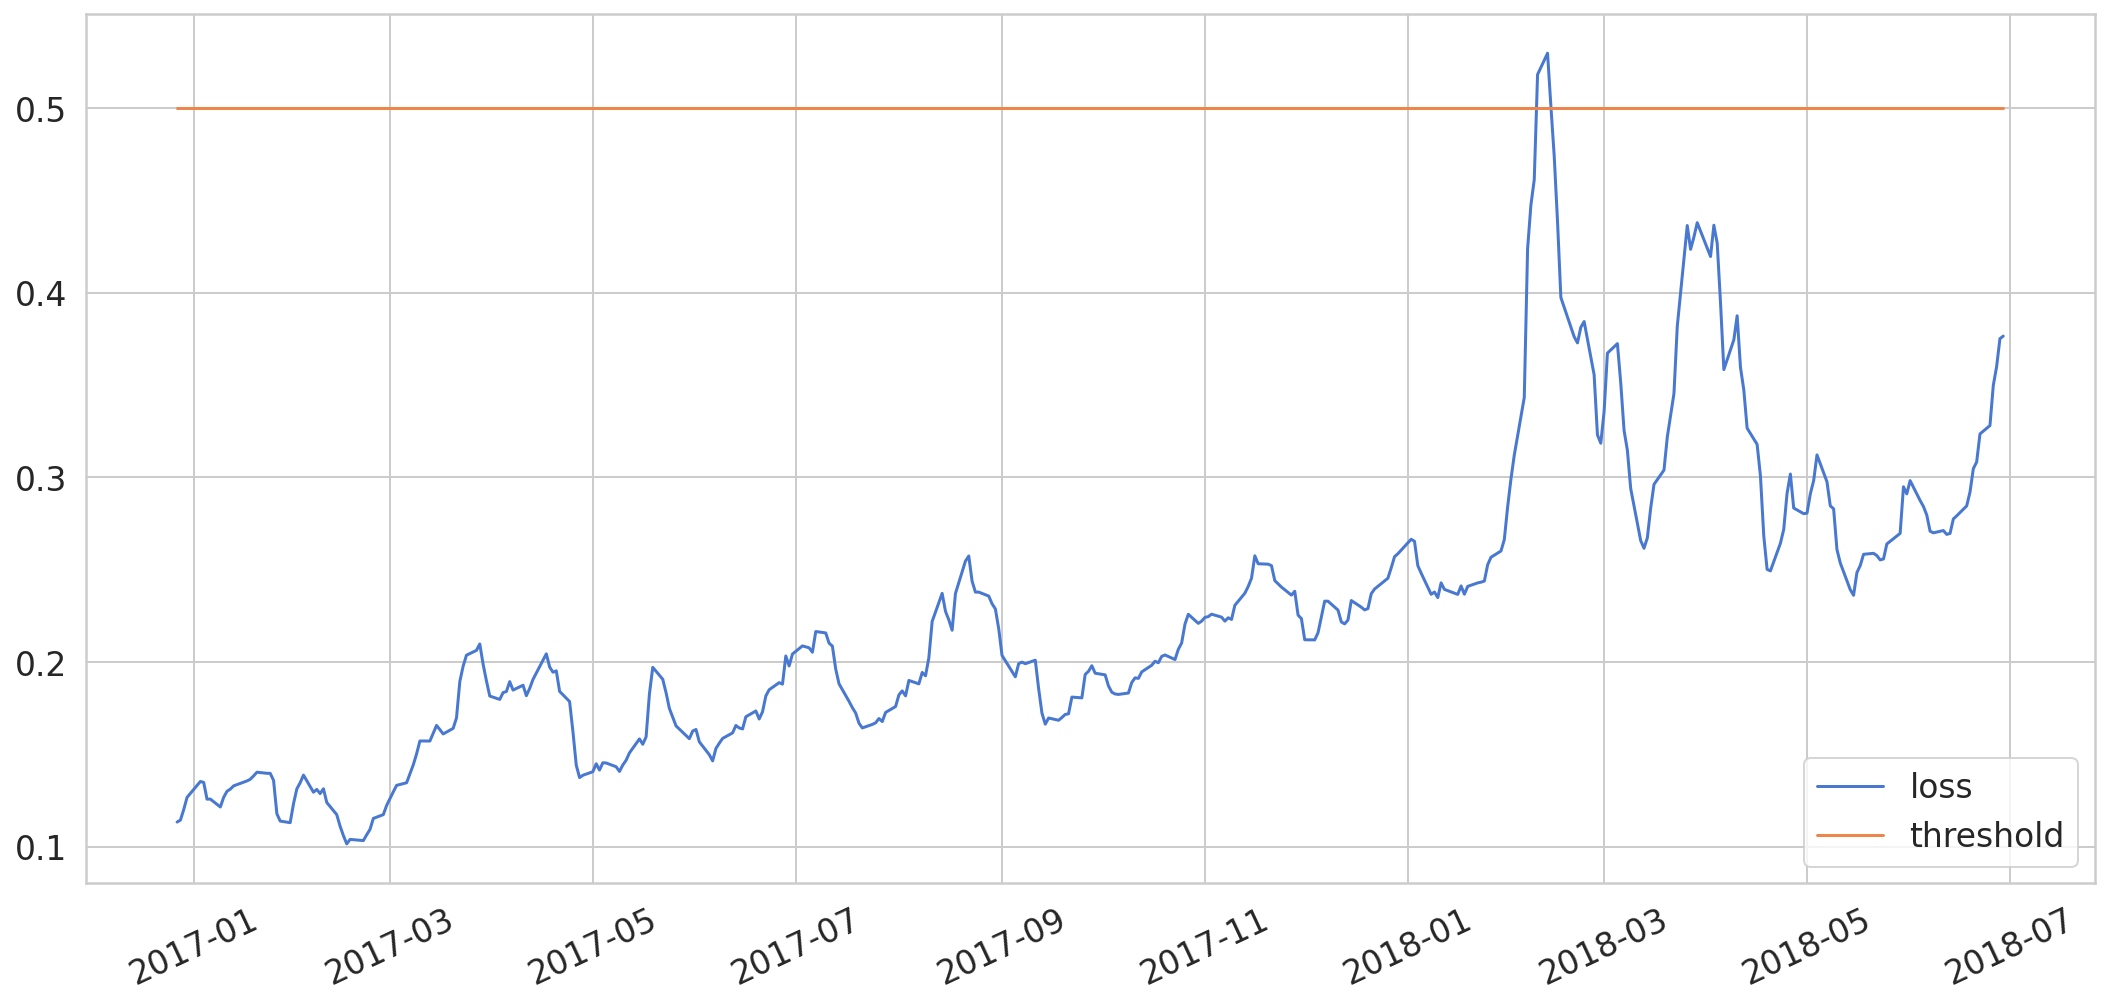

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss,label = 'loss')
plt.plot(test_score_df.index, test_score_df.threshold,label = 'threshold')
plt.xticks(rotation = 25)
plt.legend()

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-02-09,0.518096,0.5,True,3.051476
2018-02-12,0.529648,0.5,True,3.119939
2018-02-13,0.501027,0.5,True,3.132975


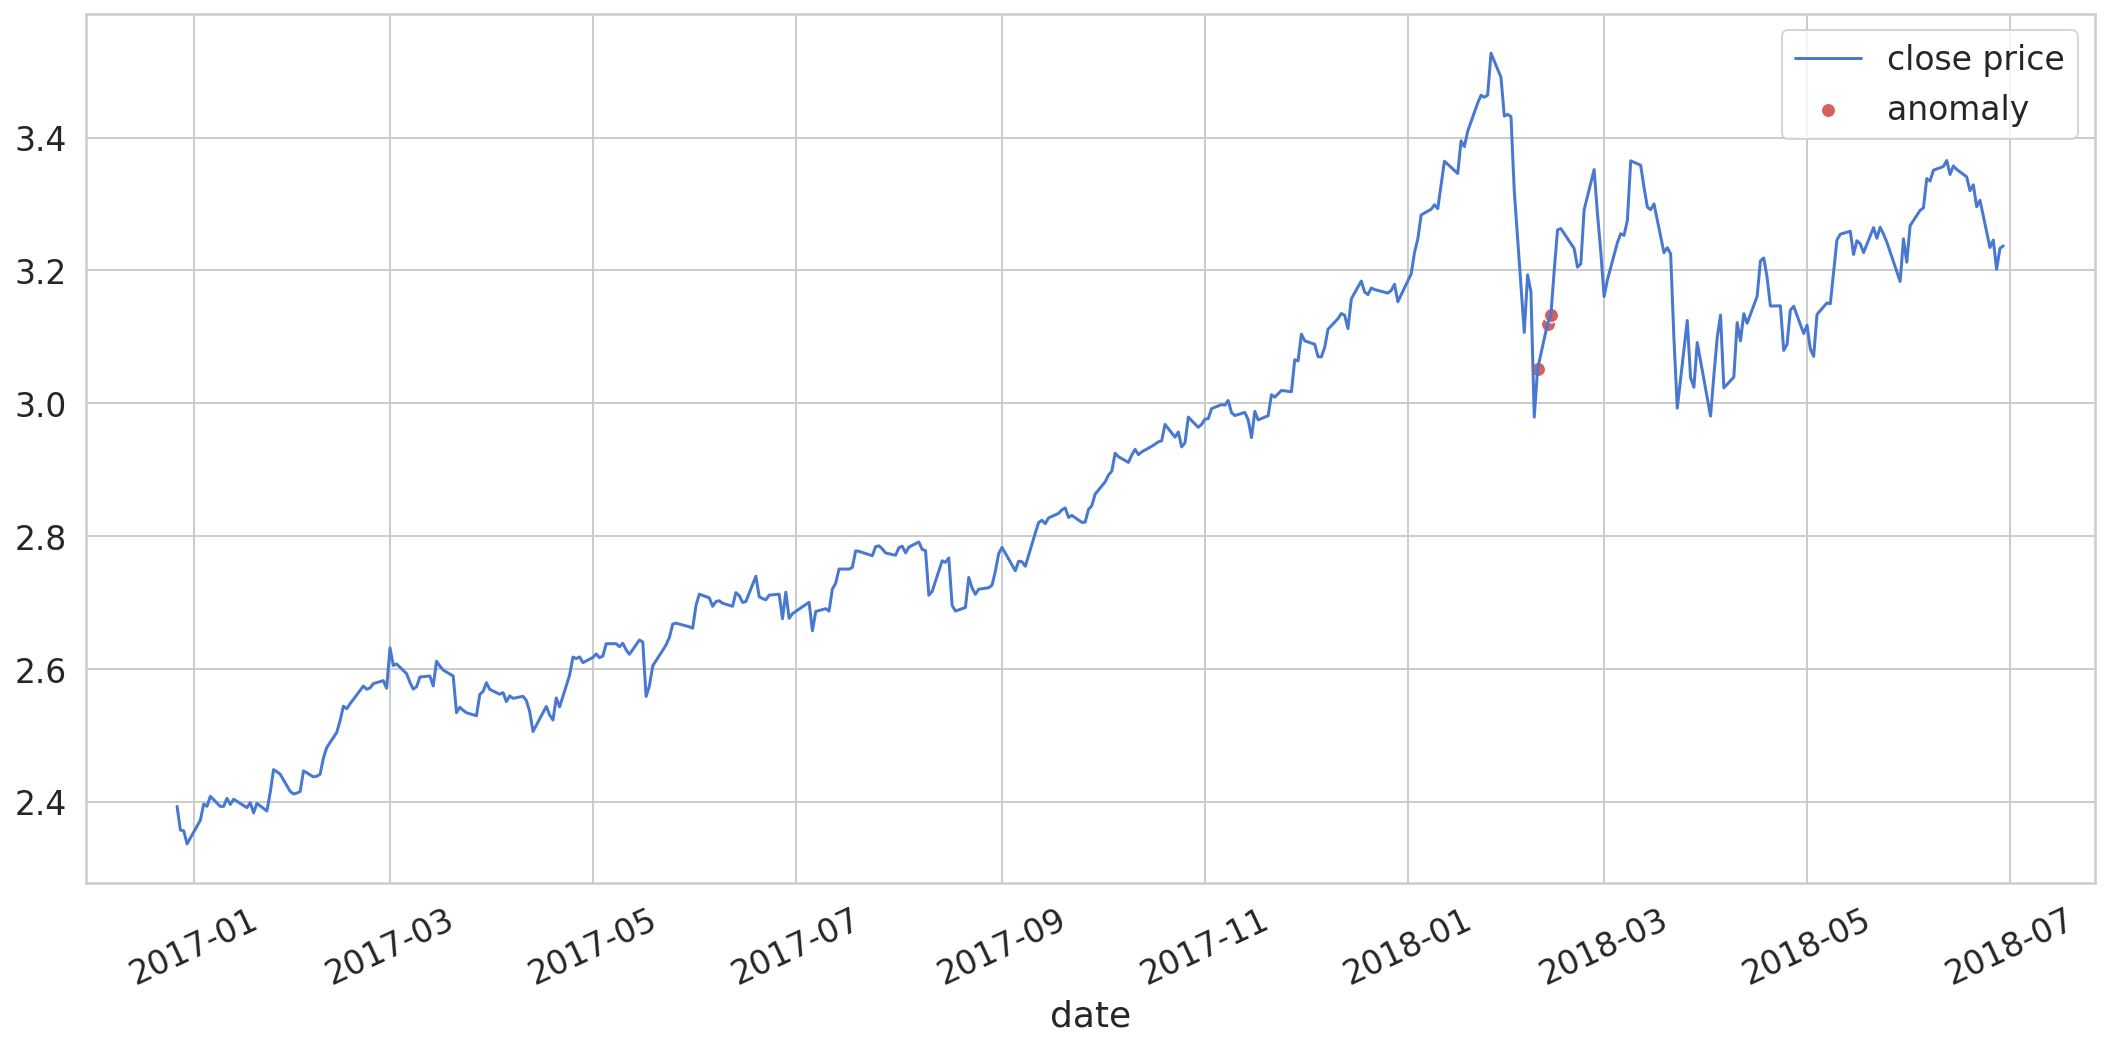

In [ ]:
plt.plot(test[TIME_STEPS:].index,
         scaler.inverse_transform(test[TIME_STEPS:].close),
         label = 'close price')
sns.scatterplot(anomalies.index,scaler.inverse_transform(anomalies.close),
                color = sns.color_palette()[3],
                s = 52, 
                label = 'anomaly')
plt.xticks(rotation = 25)
plt.legend()